In [659]:
import sys
from pathlib import Path

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Input

import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 8.5

from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.decomposition import PCA

from keras import regularizers
import keras

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




In [2]:
seed = np.random.seed(0)

# Carregar Dados

## Obter informações sobre instâncias

In [8]:
dataset_path = './Data/'

addresses, instances, events = [], [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:        
        address = os.path.join(root, file).replace('\\', '/')
        instance = address.split('/')[-1].split('.')[-2]
        event = address.split('/')[-2]
    
        addresses.append(address)
        instances.append(instance)
        events.append(event)



In [9]:
data_instances_info = np.column_stack(
    [
        addresses,
        instances,
        events,
    ]
)

data_instances_info = pd.DataFrame(data=data_instances_info, columns=['Address', 'Instance', 'Event'])
data_instances_info['id'] = np.arange(data_instances_info.shape[0])
data_instances_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Address   368 non-null    object
 1   Instance  368 non-null    object
 2   Event     368 non-null    object
 3   id        368 non-null    int32 
dtypes: int32(1), object(3)
memory usage: 10.2+ KB


In [10]:
data_instances_info

,Address,Instance,Event,id
0,./Data/4/ID 1_Well1_2.csv,ID 1_Well1_2,4,0
1,./Data/4/ID 1_Well1_7.csv,ID 1_Well1_7,4,1
2,./Data/4/ID 1_Well1_8.csv,ID 1_Well1_8,4,2
3,./Data/4/ID 1_Well2_1.csv,ID 1_Well2_1,4,3
4,./Data/4/ID 1_Well2_10.csv,ID 1_Well2_10,4,4
...,...,...,...,...
363,./Data/4/WELL-00014_20170917120016.csv,WELL-00014_20170917120016,4,363
364,./Data/4/WELL-00014_20170923160033.csv,WELL-00014_20170923160033,4,364
365,./Data/4/WELL-00014_20170923180059.csv,WELL-00014_20170923180059,4,365
366,./Data/4/WELL-00014_20170923200120.csv,WELL-00014_20170923200120,4,366


## Carregando instâncias

### Funções 

In [14]:
def load_data(
    instance_path: str, 
    periods_undersample: int or str or None = None,
):

    df = pd.read_csv(instance_path)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.index = df['timestamp']
    df = df.drop(columns=['timestamp'])

    df = df.ffill().bfill()

    df = df.fillna(0)

    # If needed, undersample by last
    if type(periods_undersample) in [int, str]:
        if type(periods_undersample) == int:
            periods_undersample = f'{periods_undersample}s'
            
        df = df.resample(periods_undersample).last()
    
    return df

In [30]:
def load_df_from_instances(
    addresses, instances, 
    events, ids,
    periods_undersample: int or str or None = None
):
    df_lst = []

    for address, instance, event, id_ in zip(addresses, instances, events, ids):
        print(address)
        df_temp = load_data(instance_path=address, periods_undersample=periods_undersample)
        df_temp['id'] = id_
        df_lst.append(df_temp)
        
    df = pd.concat(df_lst, axis=0)
    # df = df.fillna(0.0)

    return df

### Carregando instâncias

In [381]:
df = load_df_from_instances(
    addresses=data_instances_info['Address'],
    instances=data_instances_info['Instance'],
    events=data_instances_info['Event'],
    ids=data_instances_info['id'],
    periods_undersample=60
)

./Data/4/ID 1_Well1_2.csv
./Data/4/ID 1_Well1_7.csv
./Data/4/ID 1_Well1_8.csv
./Data/4/ID 1_Well2_1.csv
./Data/4/ID 1_Well2_10.csv
./Data/4/ID 1_Well2_2.csv
./Data/4/ID 1_Well2_3.csv
./Data/4/ID 1_Well2_4.csv
./Data/4/ID 1_Well2_5.csv
./Data/4/ID 1_Well2_6.csv
./Data/4/ID 1_Well2_7.csv
./Data/4/ID 1_Well2_8.csv
./Data/4/ID 1_Well2_9.csv
./Data/4/ID 1_Well3_2.csv
./Data/4/ID 1_Well3_3.csv
./Data/4/ID 1_Well3_4.csv
./Data/4/ID 1_Well3_6.csv
./Data/4/ID 1_Well3_7.csv
./Data/4/ID 1_Well5_10.csv
./Data/4/ID 1_Well5_3.csv
./Data/4/ID 1_Well5_6.csv
./Data/4/ID 1_Well5_9.csv
./Data/4/ID 1_Well6_1.csv
./Data/4/ID 1_Well6_3.csv


In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42928 entries, 2014-09-11 12:28:00 to 2014-09-12 16:14:00
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   trends_times                  42928 non-null  float64
 1   T-PDG                         42928 non-null  float64
 2   P-PDG                         42928 non-null  float64
 3   T-TPT                         42928 non-null  float64
 4   P-TPT                         42928 non-null  float64
 5   T-MON-CKP                     42928 non-null  float64
 6   P-MON-CKP                     42928 non-null  float64
 7   QOIL                          42928 non-null  float64
 8   QWATER                        42928 non-null  float64
 9   QGAS                          42928 non-null  float64
 10  T-JUS-CKP                     42928 non-null  float64
 11  P-JUS-CKP                     42928 non-null  float64
 12  WATER-SAT-MEAN           

# Selcionando instâncias que serão usadas para treinamento e teste

- Serão usadas somente instâncias que possuem os valores de pressão e temperatura nos pontos intermediarios da linha

In [383]:
intermediate_columns = [
    'T-LPO10', 'T-LPO20', 'T-LPO30', 'T-LPO40', 'T-LPO50',
    'T-LPO60', 'T-LPO70', 'T-LPO80', 'T-LPO90', 'T-LPO100',
    'P-LPO10', 'P-LPO20', 'P-LPO30','P-LPO40', 'P-LPO50', 
    'P-LPO60', 'P-LPO70', 'P-LPO80', 'P-LPO90','P-LPO100'
]

sensors_branch = [
    'T-PDG', 'P-PDG', 'T-TPT', 'P-TPT', 
    'T-MON-CKP', 'P-MON-CKP', 'T-JUS-CKP', 
    'P-JUS-CKP',
]

In [384]:
ids_to_use = []

for id in df['id'].unique():
    df_inst = df[df['id'] == id]
    
    if df_inst[intermediate_columns[0]].isna().sum() == df_inst.shape[0]:
        continue 
    
    ids_to_use.append(id)

len(ids_to_use) 

24

In [385]:
df = df[df.id.isin(ids_to_use)]

In [386]:
data_instances_info = data_instances_info[data_instances_info.id.isin(ids_to_use)]

In [387]:
data_instances_info

,Address,Instance,Event,id
0,./Data/4/ID 1_Well1_2.csv,ID 1_Well1_2,4,0
1,./Data/4/ID 1_Well1_7.csv,ID 1_Well1_7,4,1
2,./Data/4/ID 1_Well1_8.csv,ID 1_Well1_8,4,2
3,./Data/4/ID 1_Well2_1.csv,ID 1_Well2_1,4,3
4,./Data/4/ID 1_Well2_10.csv,ID 1_Well2_10,4,4
5,./Data/4/ID 1_Well2_2.csv,ID 1_Well2_2,4,5
6,./Data/4/ID 1_Well2_3.csv,ID 1_Well2_3,4,6
7,./Data/4/ID 1_Well2_4.csv,ID 1_Well2_4,4,7
8,./Data/4/ID 1_Well2_5.csv,ID 1_Well2_5,4,8
9,./Data/4/ID 1_Well2_6.csv,ID 1_Well2_6,4,9


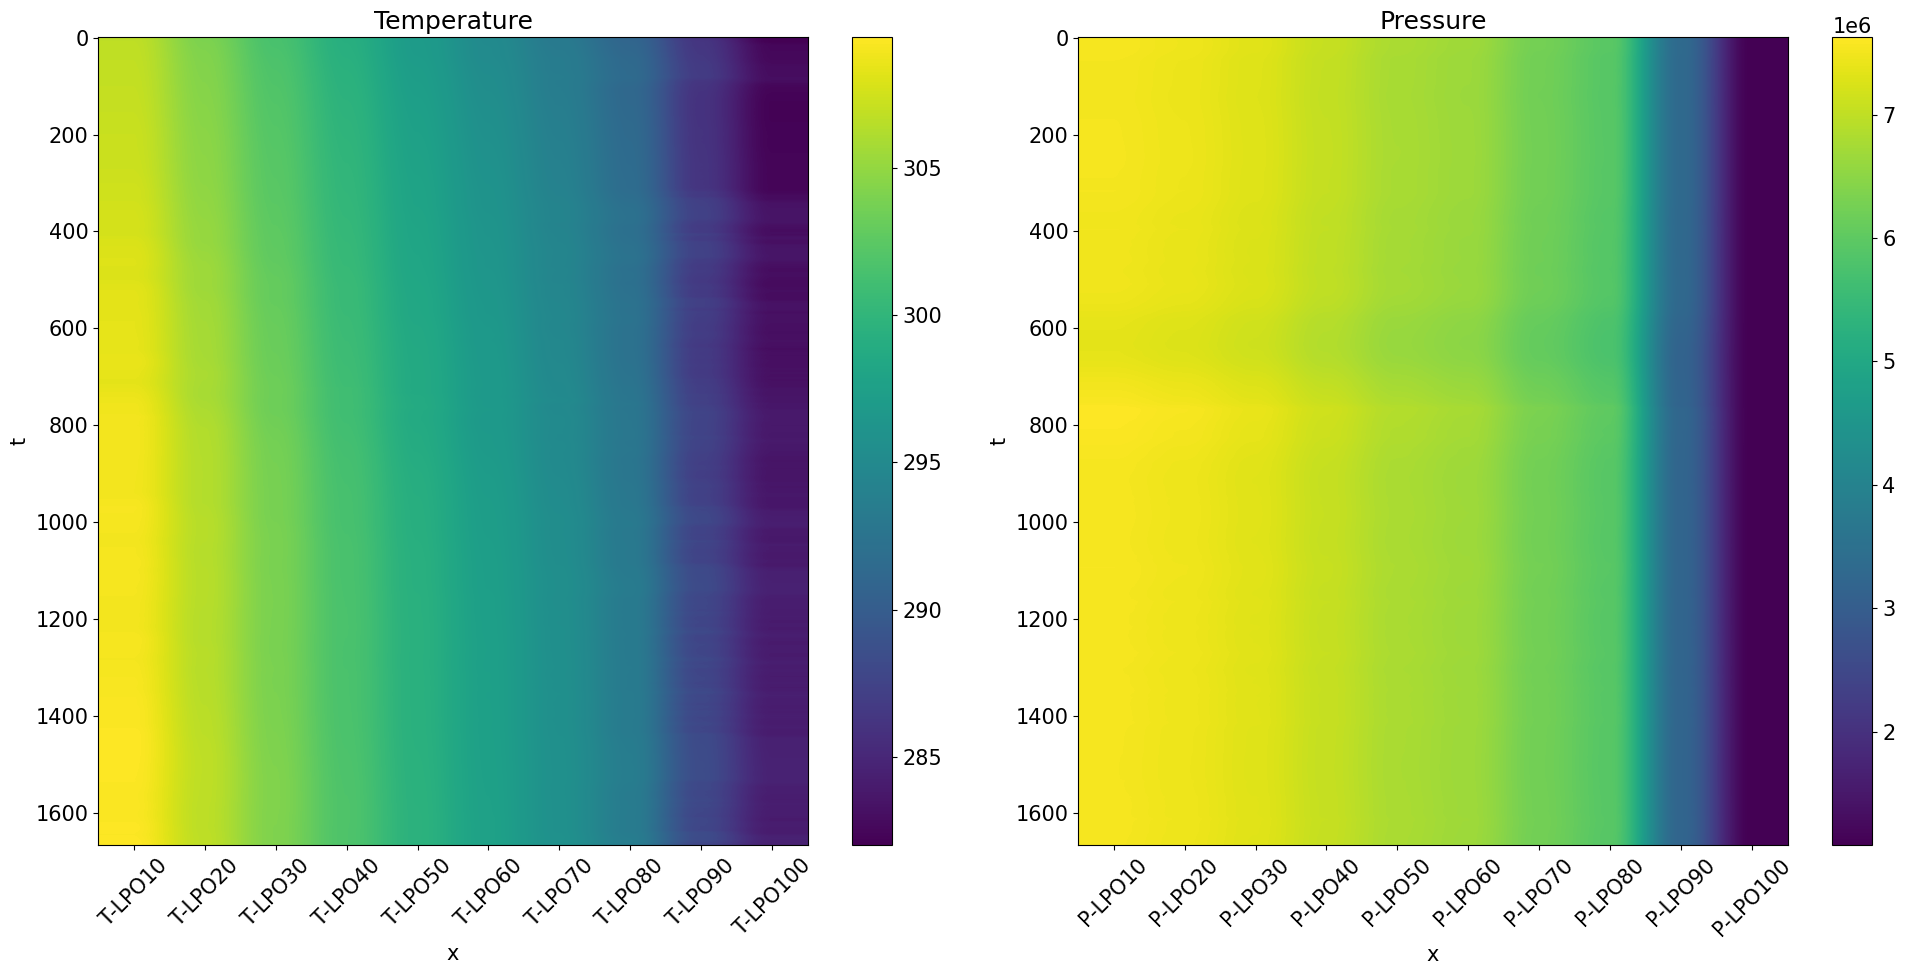

In [388]:
df_inst = df[df['id'] == 0]


intermediate_columns_temperature = [    
    'T-LPO10', 'T-LPO20', 'T-LPO30', 'T-LPO40', 'T-LPO50',
    'T-LPO60', 'T-LPO70', 'T-LPO80', 'T-LPO90', 'T-LPO100',
    ]

visualization_matrix = np.zeros((df_inst.shape[0], len(intermediate_columns_temperature)))

for i, column in enumerate(intermediate_columns_temperature):
    visualization_matrix[:, i] = df_inst[column].values

intermediate_columns_pressure = [
    'P-LPO10', 'P-LPO20', 'P-LPO30', 'P-LPO40', 'P-LPO50',
    'P-LPO60', 'P-LPO70', 'P-LPO80', 'P-LPO90', 'P-LPO100',
]

visualization_matrix_pressure = np.zeros((df_inst.shape[0], len(intermediate_columns_pressure)))

for i, column in enumerate(intermediate_columns_pressure):
    visualization_matrix_pressure[:, i] = df_inst[column].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(visualization_matrix, aspect='auto', cmap='viridis')
ax1.set_xlabel('x')
ax1.set_xticks(np.arange(len(intermediate_columns_temperature)))
ax1.set_xticklabels(intermediate_columns_temperature, rotation=45)
ax1.set_ylabel('t')
ax1.set_title('Temperature')
fig.colorbar(ax1.imshow(visualization_matrix, aspect='auto', cmap='viridis'), ax=ax1)

ax2.imshow(visualization_matrix_pressure, aspect='auto', cmap='viridis')
ax2.set_xlabel('x')
ax2.set_xticks(np.arange(len(intermediate_columns_pressure)))
ax2.set_xticklabels(intermediate_columns_pressure, rotation=45)
ax2.set_ylabel('t')
ax2.set_title('Pressure')
fig.colorbar(ax2.imshow(visualization_matrix_pressure, aspect='auto', cmap='viridis'), ax=ax2)

plt.tight_layout()
plt.show()

- Passando tempraturas nos pontos intermediarios para celsius

In [389]:
df[intermediate_columns_temperature] = df[intermediate_columns_temperature] - 273.15

In [390]:

for i in range(0, 3):
    df_inst = df[df['id'] == i]
    print(data_instances_info[data_instances_info['id'] == i].Instance.values[0])
    print(df_inst[df_inst['class'] == 4].shape, df_inst[df_inst['class'] == 0].shape)
    print('\n')

ID 1_Well1_2
(0, 67) (1228, 67)


ID 1_Well1_7
(0, 67) (1667, 67)


ID 1_Well1_8
(0, 67) (1248, 67)




- Modelo será treinado usando apenas as instâncias do Well_1. Duas instâncais serão usadas para treino e uma para teste.

In [391]:
df_train = df.loc[df['id'].isin([0, 1])]
df_test = df.loc[df['id'].isin([2])]

# Colocar dados na estrutura necessaria para entrada na DeepONet

In order to train the DeepONet for the reconstruction of the temperature and pressure field, the data used was generated by simulations and the production line was segmented in ten points besides the points available at the sensors.
$$
    (x_{PDG}, x_{TPT}, x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10}, x_{CKP})
$$
For each point in space the function f is available in the form of a time series 

$$
    f:(x, t_{i}) \rightarrow (P_x^{t_i}, T_x^{t_i}), \;  i \text{ in }(1,2,\dots n)
$$
The data matrix for the training and testing of the DeepONet has the form of:
$$         
\left [
    \begin{bmatrix}
    f(x_{PDG}, t_1),f(x_{TPT}, t_1)f(x_{CKP}, t_1) \\
    f(x_{PDG}, t_1),f(x_{TPT}, t_1)f(x_{CKP}, t_1) \\
    \vdots \\
    f(x_{PDG}, t_1),f(x_{TPT}, t_1)f(x_{CKP}, t_1) \\
    f(x_{PDG}, t_2),f(x_{TPT}, t_2)f(x_{CKP}, t_2) \\
    f(x_{PDG}, t_2),f(x_{TPT}, t_2)f(x_{CKP}, t_2) \\
    \vdots \\ 
    f(x_{PDG}, t_n),f(x_{TPT}, t_n)f(x_{CKP}, t_n)
    \end{bmatrix}
    \begin{bmatrix}
    x_1 \\
    x_2 \\
    \vdots \\
     x_n\\
     x_1\\
    x_2\\
    \vdots \\
    x_{n}
    \end{bmatrix}
    \begin{bmatrix}
    f(x_1,t_1) \\
    f(x_2,t_1)\\
    \vdots \\
    f(x_n,t_1)\\
    f(x_1,t_2)\\
    f(x_2,t_2)\\
    \vdots \\
    f(x_n, t_n)
    \end{bmatrix}
\right] 
$$


In [426]:
# Porcentagens do comprimento da linha que há valores de pressão e temperatura 

trunk_inputs = np.linspace(0.1, 1, 10)

In [393]:
X_scaler = StandardScaler()
X_scaler.fit(df_train[sensors_branch])

StandardScaler()

In [394]:
Y_scaler = StandardScaler()
Y_scaler.fit(df_train[intermediate_columns])

StandardScaler()

In [576]:
df_train_formated = []

def Data_formater_DON(
        df, 
        sensors_branch, 
        intermediate_columns, 
        trunk_inputs, 
        X_scaler, 
        Y_scaler
    ):
    
    df_train_formated = []

    for id in df['id'].unique():
        df_inst = df[df['id'] == id]

        # Obtendo os time steps da instância 
        time_index = df_inst.index

        # Normalizando os valores de entrada
        df_inst.loc[:, sensors_branch] = X_scaler.transform(df_inst[sensors_branch])

        # Normalizando os valores de saída
        df_inst.loc[:, intermediate_columns] = Y_scaler.transform(df_inst[intermediate_columns])
        
        # Traunk input
        input_trunk = []

        data_instance = []
        for time_step in time_index:
            # Para cada time step o input para a trunk network será o mesmo
        
            # Obtendo valores 
            branch_input = df_inst.loc[time_step, sensors_branch].values

            data_timestep = []
            for trunk_input in trunk_inputs:
                # Cada ponto em que a linha esta discretizada formara um par de entrada e saida para a DeepONet
                # A entrada da Branch network será o comprimento da linha em que se deseja prever a pressão e temperatura
                # A saída será a pressão e temperatura nesse ponto disponivel do dataset
                
                # Obter as colunas de saída a partir do comprimento da linha
                output_columns = [f'P-LPO{int(trunk_input*100)}', f'T-LPO{int(trunk_input*100)}']

                # Obter a saída correspondende a entrada (trunk_input) no time step atual
                output = df_inst.loc[time_step, output_columns].values
                
                # Juntar tudo em uma lista (até não funcionar mais)
                current_data = [np.array(branch_input).reshape(1, -1), 
                                np.array(trunk_input).reshape(1, -1), 
                                np.array(output).reshape(1, -1)]
                
                # Lista com os dados gerados de um mesmo time step
                data_timestep.append(current_data)

            # Lista com os dados gerados de todos os time steps de uma mesma instância
            data_instance += data_timestep

        df_train_formated += data_instance

    return df_train_formated

In [594]:
# Função que trandorma a matriz de dados em inputs para branch e trunk network e respectivos outputs

def Data_to_input_DON(inst_formated):
    X_inst_branch = []
    X_inst_trunk = []
    Y_inst = []
    for i, data in enumerate(inst_formated):
        X_inst_branch.append(data[0])
        X_inst_trunk.append(data[1])
        Y_inst.append(data[2])

    X_inst_branch = np.array(X_inst_branch).reshape(len(X_inst_branch), -1)
    X_inst_trunk = np.array(X_inst_trunk).reshape(len(X_inst_trunk), -1)
    Y_inst = np.array(Y_inst).reshape(len(Y_inst), -1)

    return X_inst_branch, X_inst_trunk, Y_inst

In [608]:
# Função para transformar os dados de saída da rede em um dataframe

def inst_pred_to_df(inst_predictions):

    df_predictions = pd.DataFrame(columns=intermediate_columns)

    for i in range (0, int(len(inst_predictions)/10)):
        begin_index = 10*i
        end_index =  (10*i + 10)

        predict_dict = dict()

        time_step_pred = inst_predictions[begin_index:end_index]

        for j, trunk_input in enumerate(trunk_inputs):
            predict_dict[f'P-LPO{int(trunk_input*100)}'] = time_step_pred[j][0] 
            predict_dict[f'T-LPO{int(trunk_input*100)}'] = time_step_pred[j][1]

        df_predict_time_step = pd.DataFrame([predict_dict])

        # df_predictions.iloc[i] =predict_dict 
        df_predictions = pd.concat([df_predictions, df_predict_time_step], axis=0)

    df_predictions.columns = intermediate_columns

    return df_predictions

O tamanho dos dados que servirão de entrada para o DeepONet deve ser 10 vezes a quantidadede de obsrvações do dataframe original com as instâncias

In [596]:
df_train_formated = Data_formater_DON(
    df_train, 
    sensors_branch, 
    intermediate_columns, 
    trunk_inputs, 
    X_scaler, 
    Y_scaler
)

In [597]:
len(df_train_formated), df_train.shape[0]

(33340, 3334)

# Definindo arquitetura da DeepONet 

In [399]:
def create_model(verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net input
    branch_input = tf.keras.Input(shape=len(sensors_branch))
    #branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)

    branch = tf.keras.layers.Dense(32, activation="elu")(branch_input)
    branch = tf.keras.layers.Dense(32, activation="elu")(branch)
    branch = tf.keras.layers.Dense(10, activation="elu")(branch)

    # Trunk net input
    trunk_input = tf.keras.Input(shape=1)
    #trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)

    trunk = tf.keras.layers.Dense(16, activation="elu")(trunk_input)
    trunk = tf.keras.layers.Dense(16, activation="elu")(trunk)
    trunk = tf.keras.layers.Dense(10, activation="elu")(trunk)

    # Compute the dot product between branch and trunk net
    # dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Concatenate the branch and trunk net output
    concat = tf.keras.layers.Concatenate()([branch, trunk])

    # Mixing net
    Mix = tf.keras.layers.Dense(15, activation="elu")(concat)
    Mix = tf.keras.layers.Dense(5, activation="elu")(Mix)

    # Output is two dimension vector (Linear activation function) 
    output = tf.keras.layers.Dense(2)(Mix)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

In [400]:
DoN = create_model(verbose=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 32)           288         ['input_7[0][0]']                
                                                                                                  
 dense_30 (Dense)               (None, 16)           32          ['input_8[0][0]']                
                                                                                            

# Separando dados do conjunto de treino

In [ ]:
X_train_branch, X_train_trunk, Y_train = Data_to_input_DON(df_train_formated)

print(X_train_branch.shape, X_train_trunk.shape, Y_train.shape)

(33340, 8) (33340, 1) (33340, 2)


# Treinando DeepONet

In [402]:
DoN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse', 
    metrics=[RootMeanSquaredError()])

DoN.fit([X_train_branch, X_train_trunk], Y_train, epochs=100, batch_size=32)

Epoch 1/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.1273 - root_mean_squared_error: 0.3568
Epoch 2/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0574 - root_mean_squared_error: 0.2397
Epoch 3/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880
Epoch 4/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408
Epoch 5/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122
Epoch 6/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068
Epoch 7/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031
Epoch 8/100
1042/1042 [==============================] - 1s 1ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021
Epoch 9/100
1042/1042 [==============================] -

# Realizar avaliações

- Dados de treinamento

In [638]:
predictions = DoN.predict([X_train_branch, X_train_trunk])

mse = mean_squared_error(Y_train, predictions)
r2 = r2_score(Y_train, predictions)

print(f'MSE: {mse}, R2: {r2}')

1042/1042 [==============================] - 1s 939us/step
MSE: 0.004640830583595951, R2: 0.9952378654809317


- Dados de teste

In [639]:
inst_formated = Data_formater_DON(
    df_test, 
    sensors_branch, 
    intermediate_columns, 
    trunk_inputs, 
    X_scaler, 
    Y_scaler
)

X_test_branch, X_test_trunk, y_test = Data_to_input_DON(inst_formated)

print(X_test_branch.shape, X_test_trunk.shape, y_test.shape)

(16670, 8) (16670, 1) (16670, 2)


In [640]:
test_predictions = DoN.predict([X_test_branch, X_test_trunk])

mse = mean_squared_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f'MSE: {mse}, R2: {r2}')

521/521 [==============================] - 0s 696us/step
MSE: 0.04899265007913932, R2: 0.824237964694515


## Reconstrução dos campos

In [643]:
def plot_fields(df_predictions):
    temp_visualization_matrix = np.zeros((df_predictions.shape[0], len(intermediate_columns_temperature)))
    press_visualization_matrix = np.zeros((df_predictions.shape[0], len(intermediate_columns_pressure)))

    for i in range(0, df_predictions.shape[0]):
        temp_visualization_matrix[i, :] = df_predictions[i, :10]
        press_visualization_matrix[i, :] = df_predictions[i, 10:]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(temp_visualization_matrix, aspect='auto', cmap='viridis')
    ax1.set_xlabel('x')
    ax1.set_xticks(np.arange(len(intermediate_columns_temperature)))
    ax1.set_xticklabels(intermediate_columns_temperature, rotation=45)
    ax1.set_ylabel('t')
    ax1.set_title('Temperature')
    fig.colorbar(ax1.imshow(temp_visualization_matrix, aspect='auto', cmap='viridis'), ax=ax1)

    ax2.imshow(press_visualization_matrix, aspect='auto', cmap='viridis')
    ax2.set_xlabel('x')
    ax2.set_xticks(np.arange(len(intermediate_columns_pressure)))
    ax2.set_xticklabels(intermediate_columns_pressure, rotation=45)
    ax2.set_ylabel('t')
    ax2.set_title('Pressure')
    fig.colorbar(ax2.imshow(press_visualization_matrix, aspect='auto', cmap='viridis'), ax=ax2)

    plt.tight_layout()
    plt.show()

In [661]:
def plot_fields_error(df_predictions, df_inst):
    temp_visualization_matrix_inf = np.zeros((df_predictions.shape[0], len(intermediate_columns_temperature)))
    press_visualization_matrix_inf = np.zeros((df_predictions.shape[0], len(intermediate_columns_pressure)))

    for i in range(0, df_predictions.shape[0]):
        temp_visualization_matrix_inf[i, :] = df_predictions[i, :10]
        press_visualization_matrix_inf[i, :] = df_predictions[i, 10:]

    temp_visualization_matrix_true = np.zeros((df_predictions.shape[0], len(intermediate_columns_temperature)))
    press_visualization_matrix_true = np.zeros((df_predictions.shape[0], len(intermediate_columns_pressure)))

    for i in range(0, df_predictions.shape[0]):
        temp_visualization_matrix_true[i, :] = df_inst[intermediate_columns].iloc[i][:10].values
        press_visualization_matrix_true[i, :] = df_inst[intermediate_columns].iloc[i][10:].values


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


    temp_error = abs((temp_visualization_matrix_inf - temp_visualization_matrix_true)/temp_visualization_matrix_true)*100
    ax1.imshow(temp_error, aspect='auto', cmap='hot')
    ax1.set_xlabel('x')
    ax1.set_xticks(np.arange(len(intermediate_columns_temperature)))
    ax1.set_xticklabels(intermediate_columns_temperature, rotation=45)
    ax1.set_ylabel('t')
    ax1.set_title('Temperature relative Error')
    fig.colorbar(ax1.imshow(temp_error, aspect='auto', cmap='hot'), ax=ax1)


    pressure_error = abs((press_visualization_matrix_inf - press_visualization_matrix_true)/press_visualization_matrix_true)*100
    ax2.imshow(pressure_error, aspect='auto', cmap='hot')
    ax2.set_xlabel('x')
    ax2.set_xticks(np.arange(len(intermediate_columns_pressure)))
    ax2.set_xticklabels(intermediate_columns_pressure, rotation=45)
    ax2.set_ylabel('t')
    ax2.set_title('Pressure relative Error')
    fig.colorbar(ax2.imshow(pressure_error, aspect='auto', cmap='hot'), ax=ax2)

    plt.tight_layout()
    plt.show()

### Instancias de treinamento

================ 0 ================


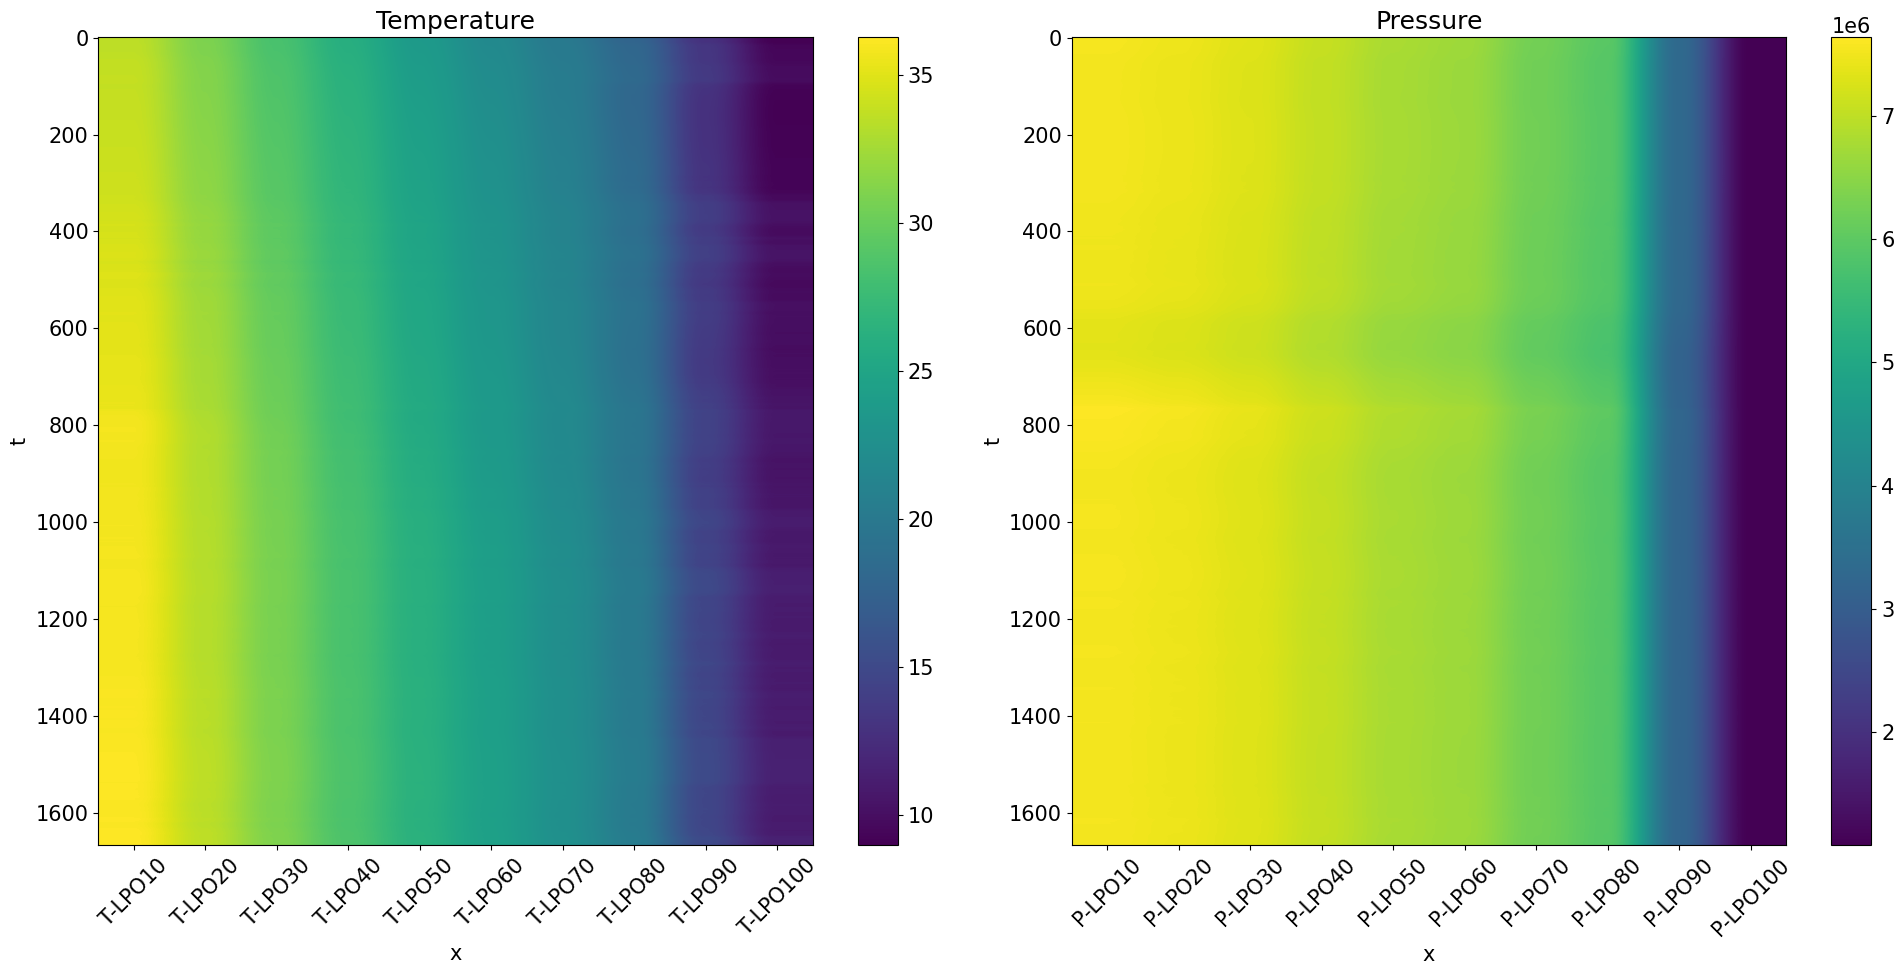

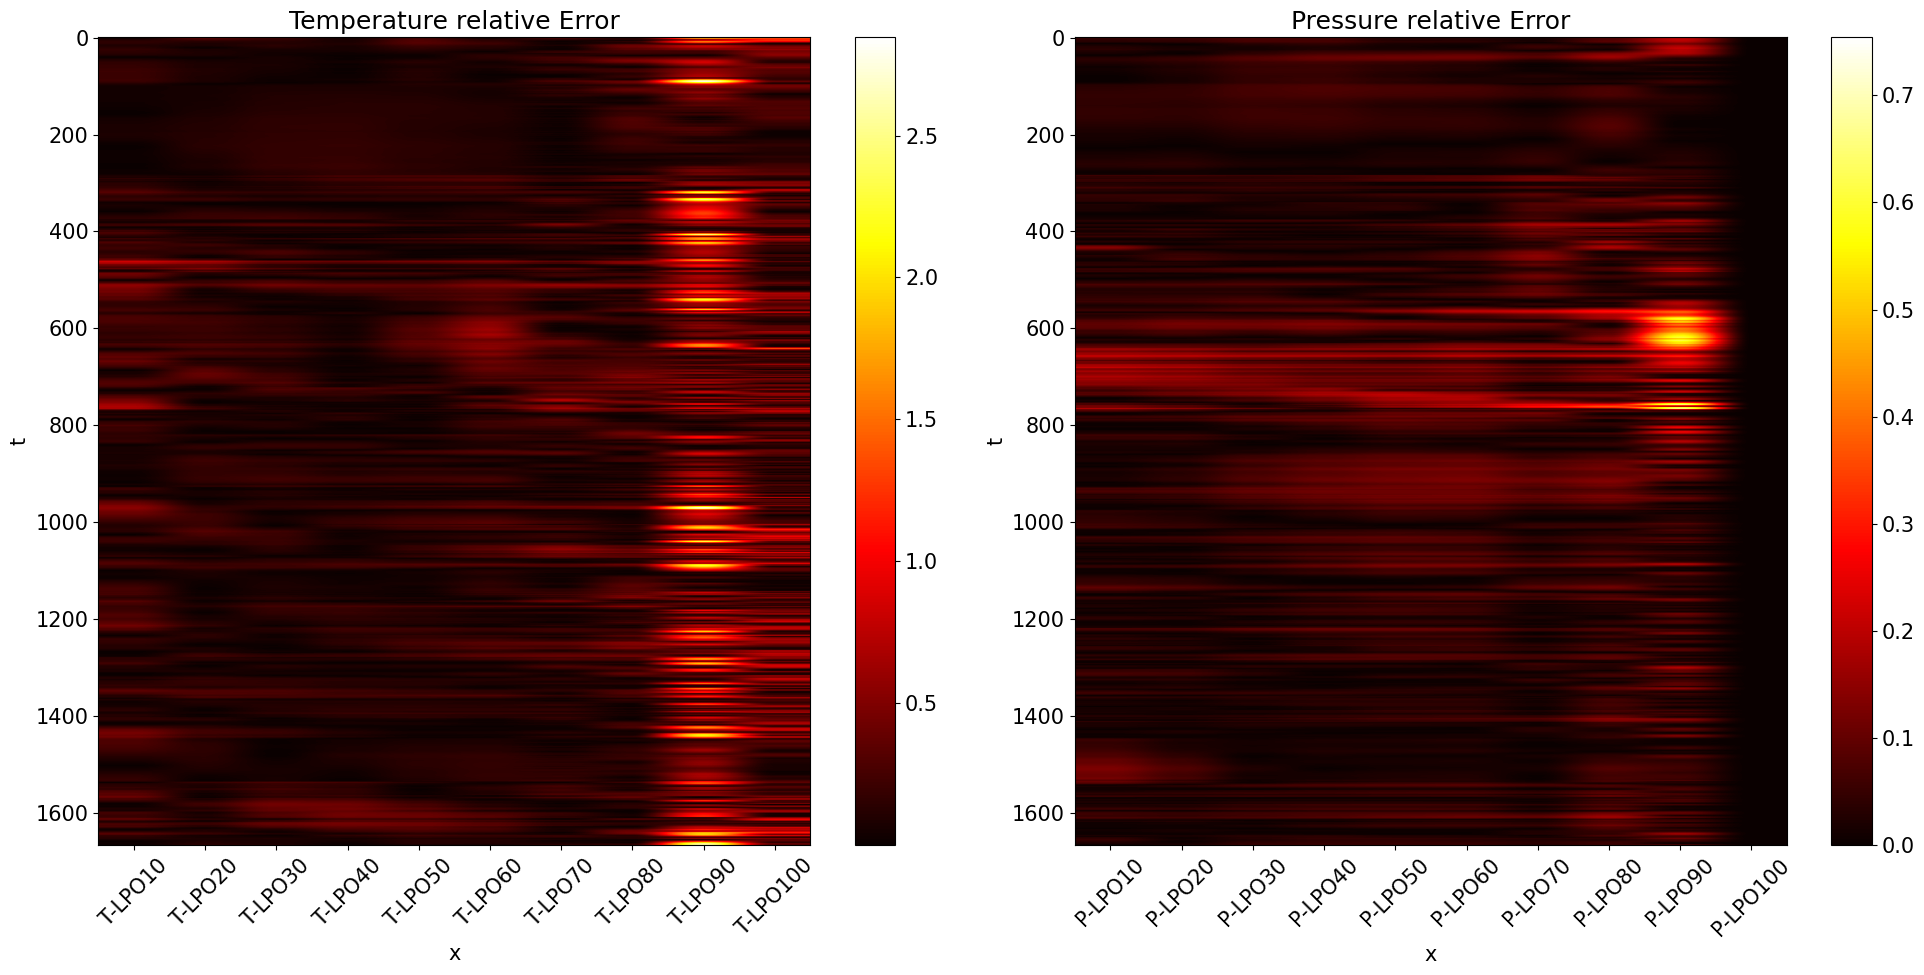

================ 1 ================


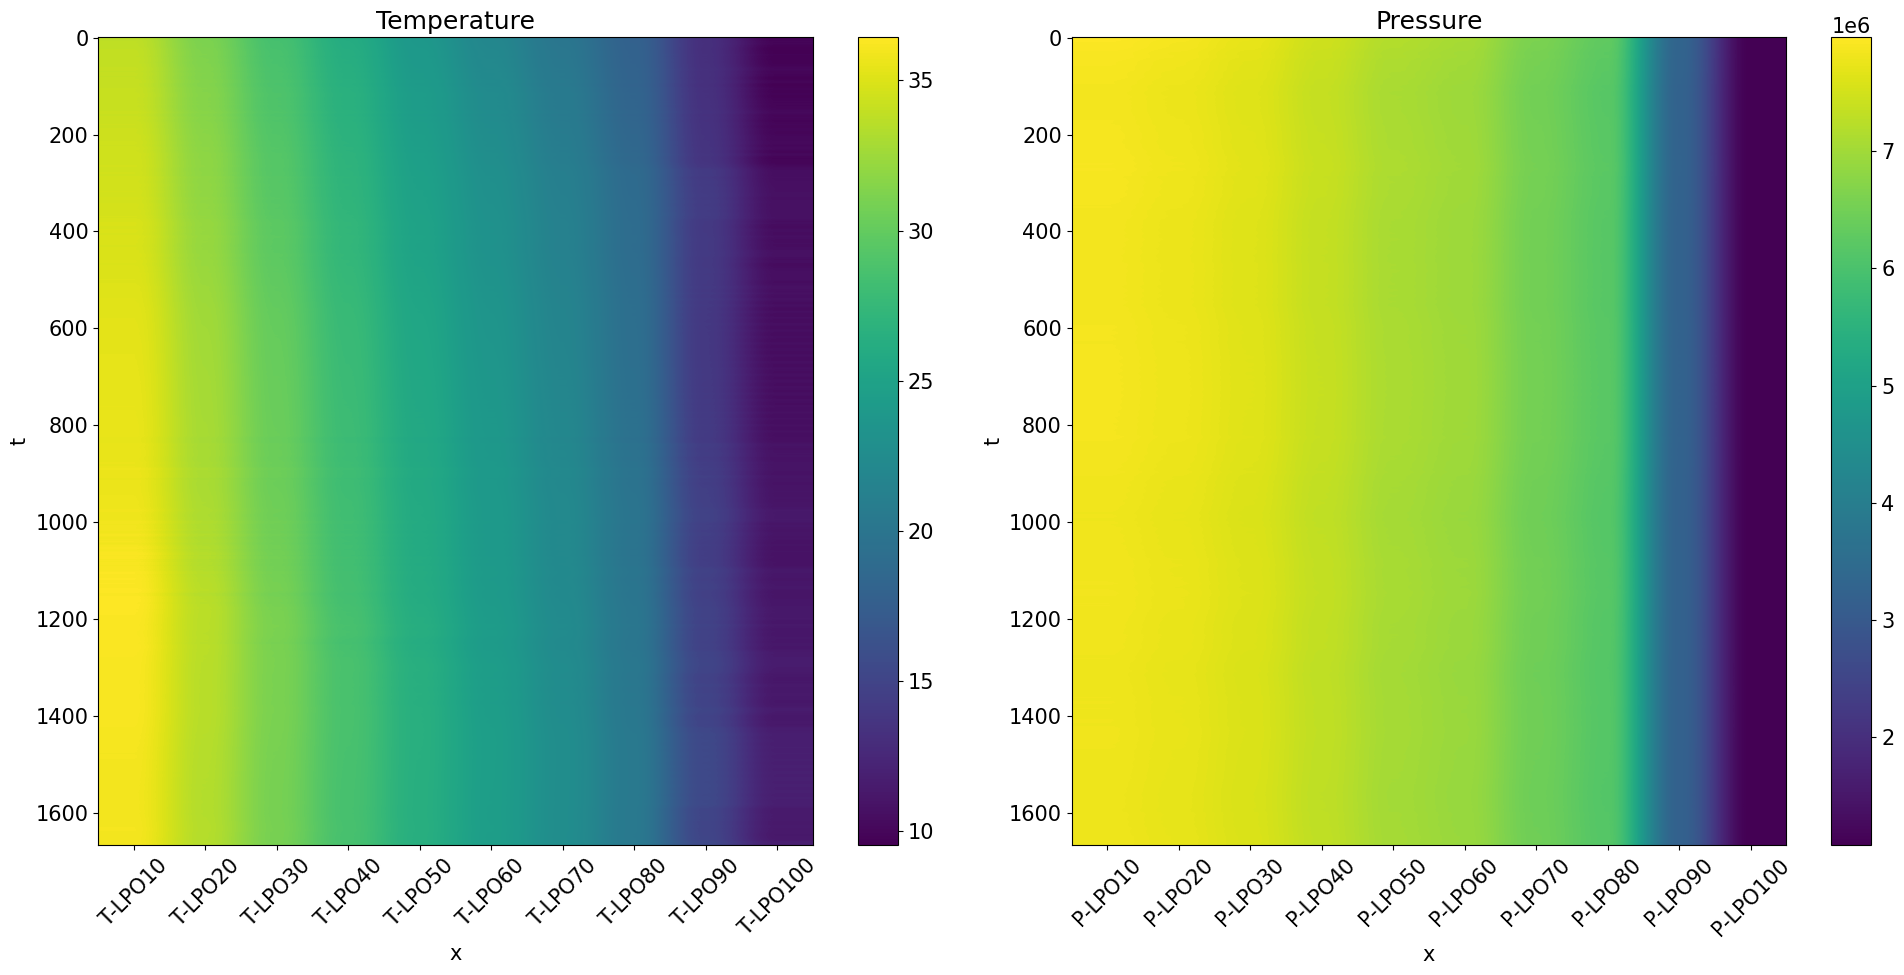

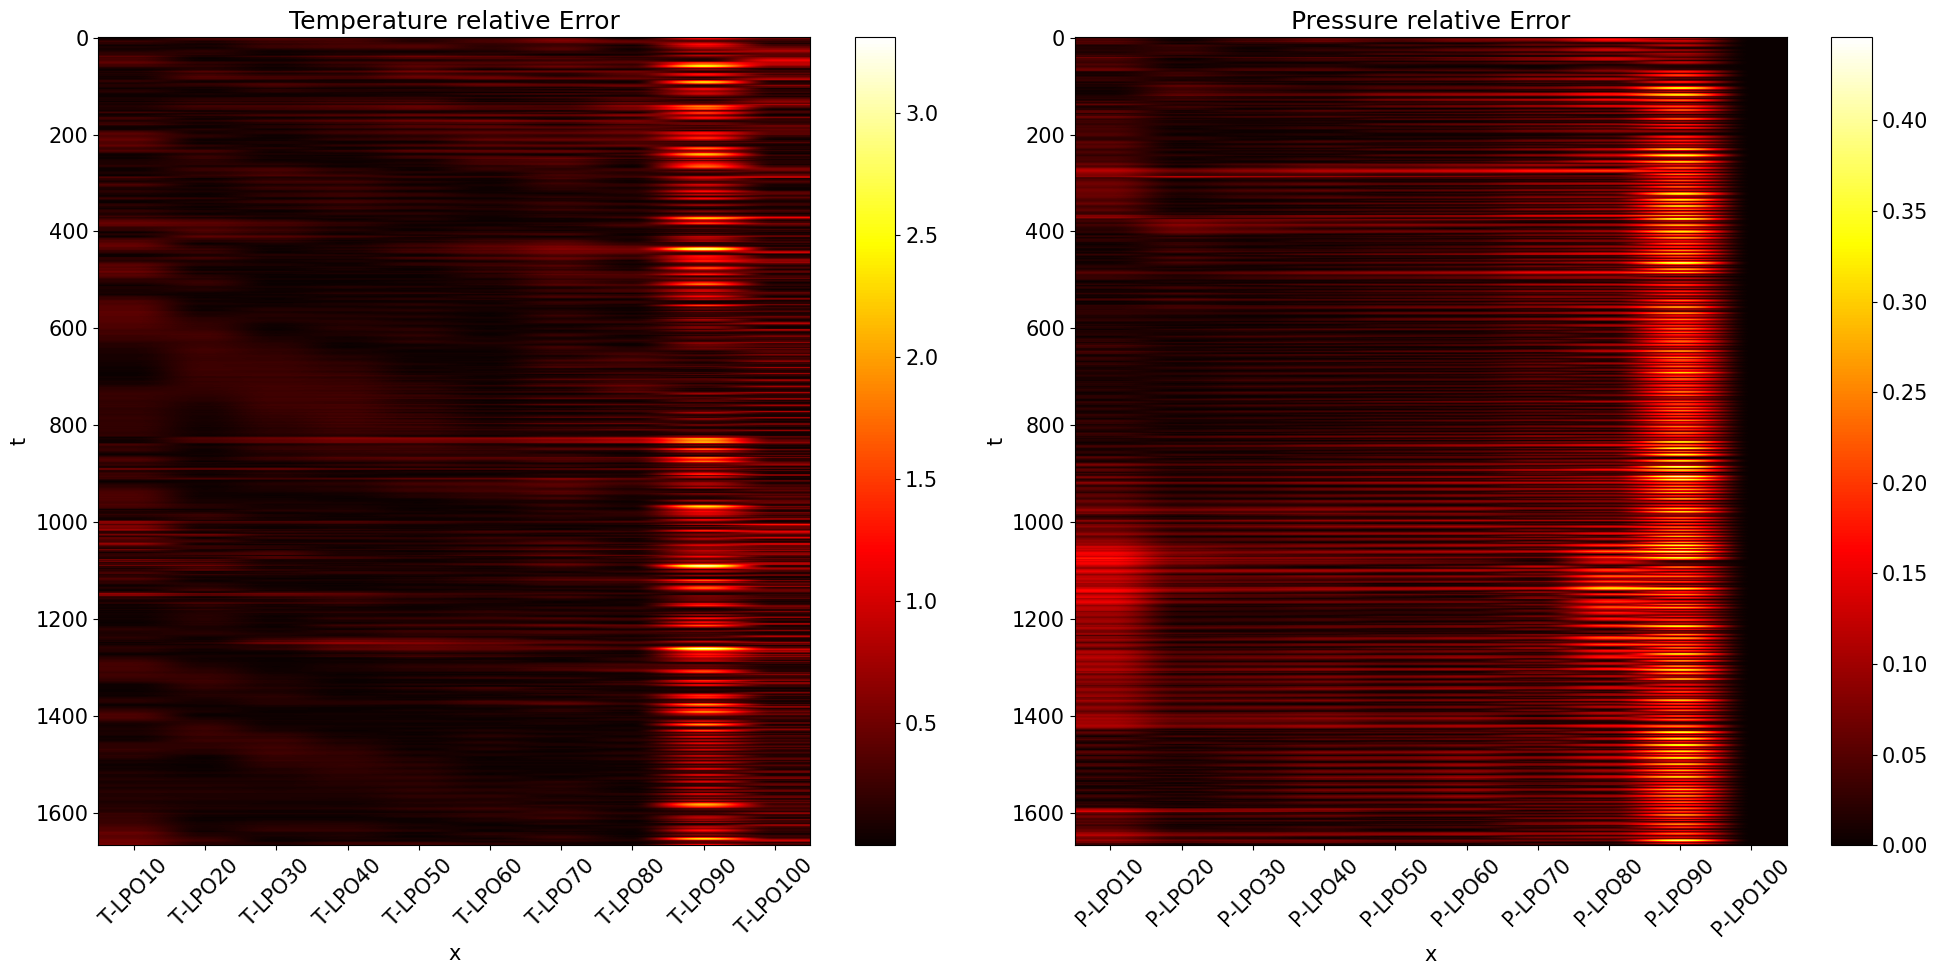

In [668]:
for id in df_train['id'].unique():
    print(f'================ {id} ================')
    df_inst = df_train[df_train['id'] == id]

    inst_formated = Data_formater_DON(
        df_inst, 
        sensors_branch, 
        intermediate_columns, 
        trunk_inputs, 
        X_scaler, 
        Y_scaler
    )

    X_inst_branch, X_inst_trunk, y_inst = Data_to_input_DON(inst_formated)

    inst_predictions = DoN.predict([X_inst_branch, X_inst_trunk], verbose=0)

    df_predictions = inst_pred_to_df(inst_predictions)

    inversed_tranform_predictions = Y_scaler.inverse_transform(df_predictions)

    plot_fields(inversed_tranform_predictions)

    plot_fields_error(inversed_tranform_predictions, df_inst)

### Instâncias de teste

================ 2 ================


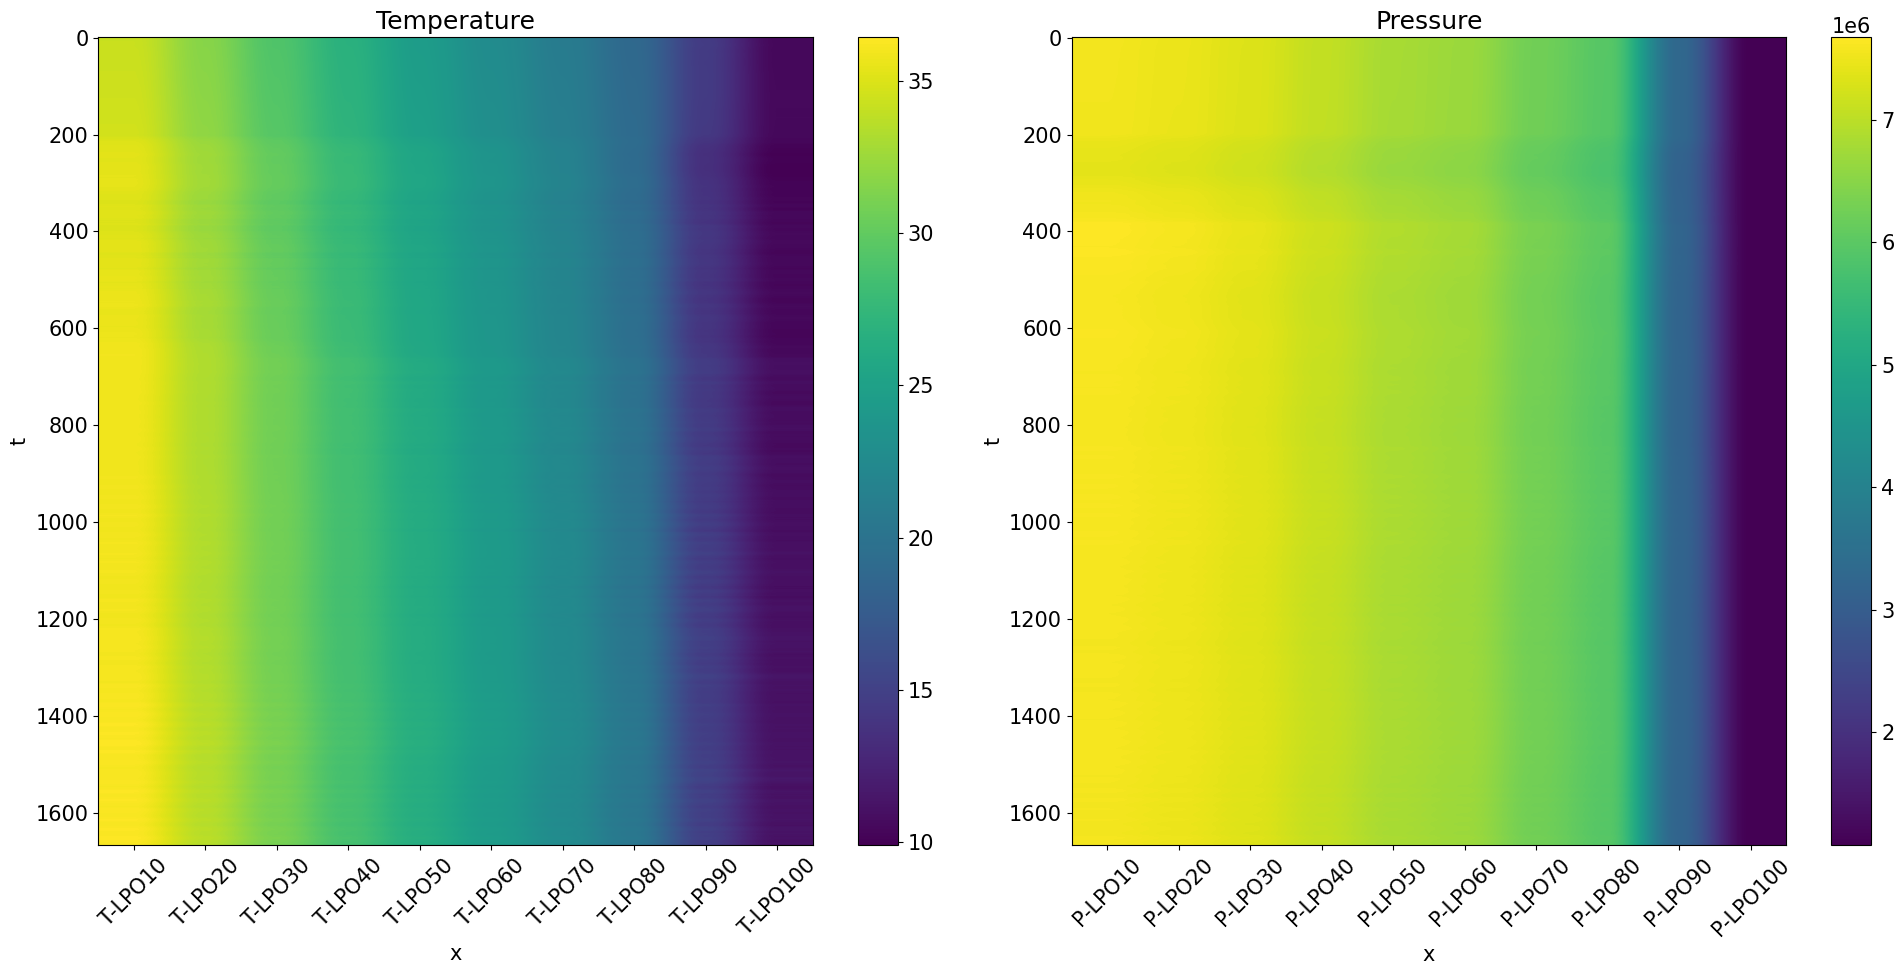

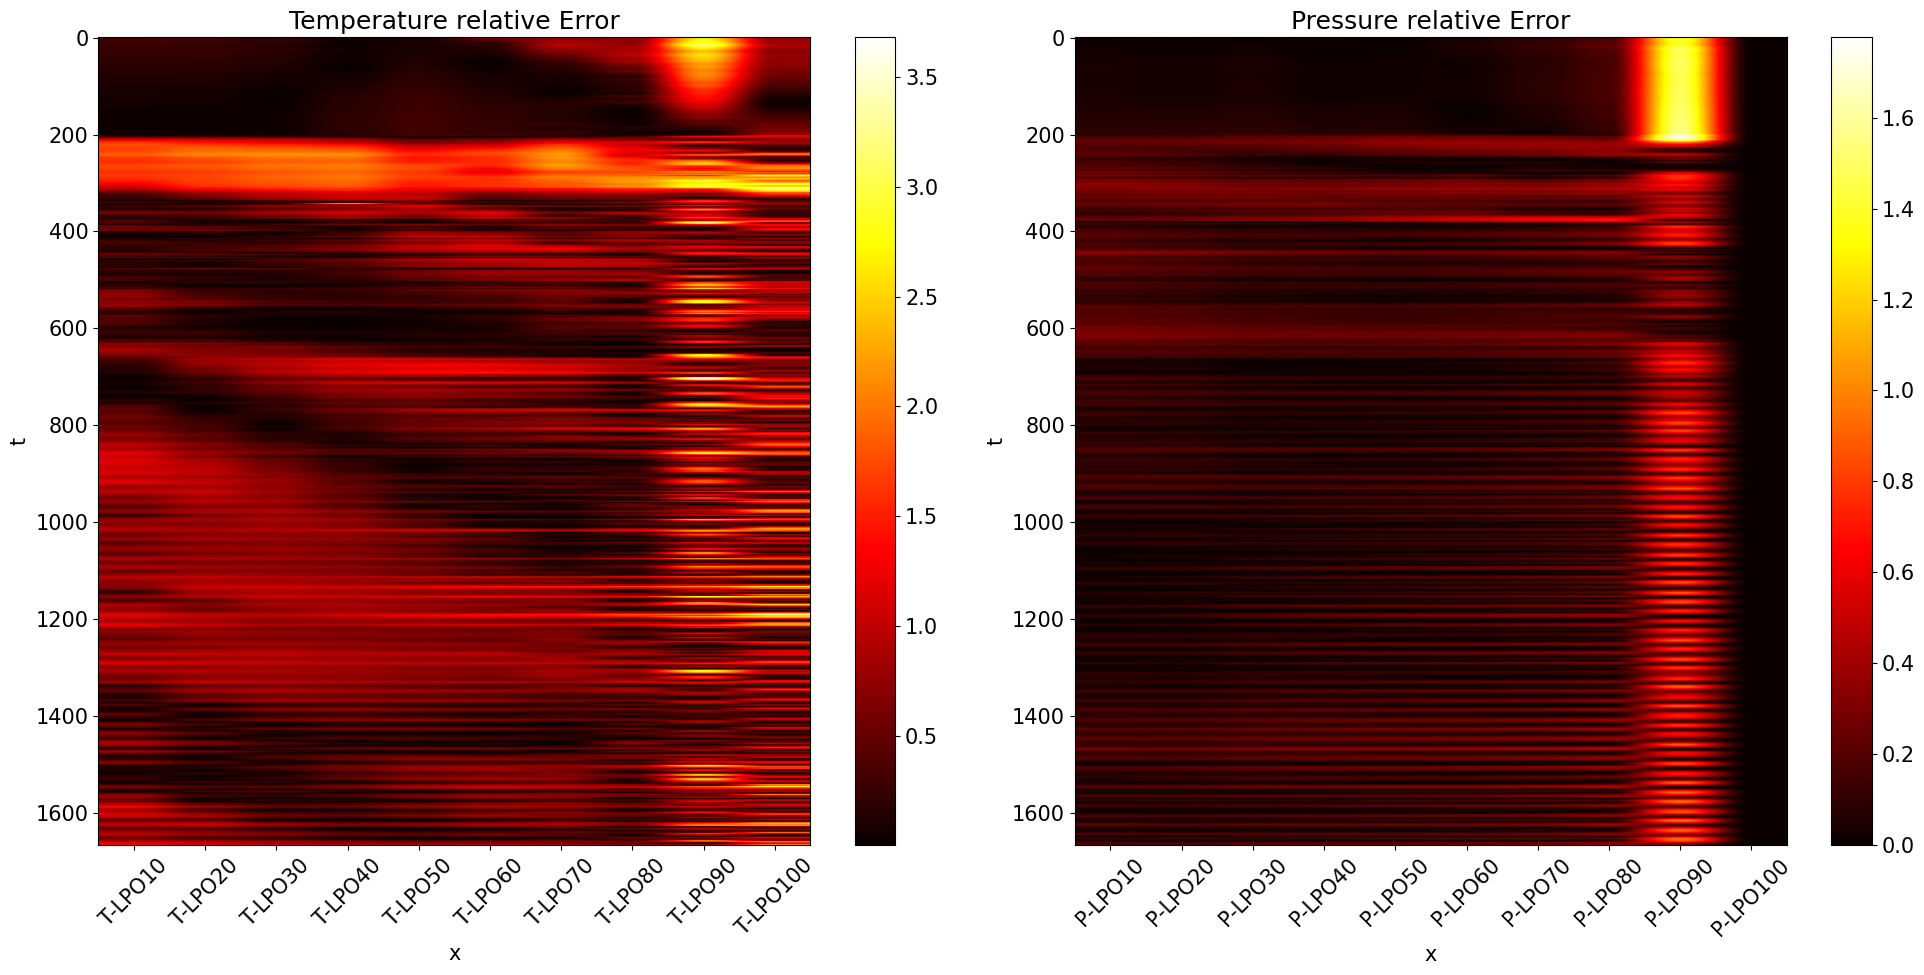

In [669]:
for id in df_test['id'].unique():
    print(f'================ {id} ================')
    df_inst = df_test[df_test['id'] == id]

    inst_formated = Data_formater_DON(
        df_inst, 
        sensors_branch, 
        intermediate_columns, 
        trunk_inputs, 
        X_scaler, 
        Y_scaler
    )

    X_inst_branch, X_inst_trunk, y_inst = Data_to_input_DON(inst_formated)

    inst_predictions = DoN.predict([X_inst_branch, X_inst_trunk], verbose=0)

    df_predictions = inst_pred_to_df(inst_predictions)

    inversed_tranform_predictions = Y_scaler.inverse_transform(df_predictions)

    plot_fields(inversed_tranform_predictions)

    plot_fields_error(inversed_tranform_predictions, df_inst)